In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler # for preprocessing the data
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
from sklearn.svm import SVC # for SVM classification
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn_pandas import CategoricalImputer
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.pipeline import Pipeline
import pickle
from fancyimpute import NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
from keras.models import Sequential
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, Embedding, Reshape,add
from keras.layers.merge import concatenate
from keras.models import Model
import datetime
import os
from resample_forest import ResampleForestClassifier
from sklearn.ensemble import IsolationForest


In [3]:


df=pd.read_csv('data/saftey_efficay_myopiaTrain.csv')
dftestsubmision=pd.read_csv('data/saftey_efficay_myopiaTest.csv')



C:\Users\mor\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (1,2,4,13,32,33,34,38,41,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:

#drop empty rows
df=df.dropna(how='all')
df=df.replace(' ',np.nan)
df.columns=df.columns.str.replace('[%.]','')
columns=df.columns
dftestsubmision.columns=dftestsubmision.columns.str.replace('[%.]','')
dftestsubmision['Class']=0


In [5]:

X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    dftrain, dftest = df.iloc[train_index], df.iloc[test_index]



TRAIN: [16920 16063  8486 ... 16912  7980  7791] TEST: [  738  5494 12545 ... 18085 29281  5230]


In [ ]:

# =============================================================================
#     only when submit
# =============================================================================
dftrain=df.copy() 



In [6]:


def heatMap(df, mirror=True, filename=False,annot=False):

    # Create Correlation df
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(12, 12))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
    if mirror == True:
       #Generate Heat Map, allow annotations and place floats in map
       sns.heatmap(corr, cmap=colormap, annot=annot, fmt=".2f")

    else:
       # Drop self-correlations
       dropSelf = np.zeros_like(corr)
       dropSelf[np.triu_indices_from(dropSelf)] = True# Generate Color Map
       colormap = sns.diverging_palette(220, 10, as_cmap=True)
       
    if filename:
        plt.savefig(filename)
    plt.show()




In [7]:

dftrain.info() 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 24360 entries, 16920 to 7791
Data columns (total 52 columns):
D_L_Age                                  24360 non-null float64
D_L_Sex                                  23586 non-null object
D_L_Eye                                  24360 non-null object
D_L_From_this_Treat_until_last_Optalm    24360 non-null float64
D_L_Dominant_Eye                         12209 non-null object
Pre_L_Pupil_Day                          116 non-null float64
Pre_L_Pupil_Night                        12866 non-null float64
Pre_L_Pachymetry                         23019 non-null float64
Pre_L_Average_K                          21316 non-null float64
Pre_L_K_Minimum                          18625 non-null float64
Pre_L_K_Maximum                          18636 non-null float64
Pre_L_Steep_Axis_max                     18361 non-null float64
Pre_L_Steep_Axis_min                     18438 non-null float64
Pre_L_Contact_Lens                       21125 non-null objec

In [8]:

'''
# =============================================================================
# delete by rows
# =============================================================================
'''

def rowdist(df):
    df1=df.isnull().sum(axis=1).sort_values().to_frame()
    classes=df.loc[list(df1.index),'Class'].to_frame()
    df2=pd.concat([df1, classes], axis=1, sort=False)
    df2.columns = ['Count', 'Class']
    return df2


def findZeroTodelete(df,tr=0):
    mini=0
    if tr!=0:
        return tr
    for i in df.Count.sort_values(ascending=False).values:
        if df[df.Count>=i].Class.sum()==0:
            mini=i
        else:
            return mini            
    return mini

def findIndicesToDelete(df,Count):
    return list(df[df.Count>=Count].index)



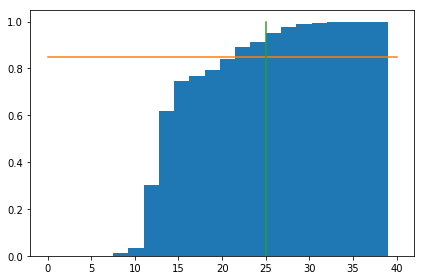

In [9]:

df2=rowdist(dftrain)
plt.hist(x='Count',data=df2,bins=20,density=True,cumulative=True)
plt.plot([0,40],[0.85,0.85])
plt.plot([25,25],[0,1])
plt.tight_layout()
plt.show()    



In [10]:


r=findZeroTodelete(df2,0)
indicesToDelete=findIndicesToDelete(df2,r)
print(len(indicesToDelete))


71


In [11]:

print(dftrain.shape)
dftrain=dftrain.drop(indicesToDelete)
print(dftrain.shape)



(24360, 52)
(24289, 52)


In [12]:

'''
# =============================================================================
# delete by columns
# =============================================================================
'''

def miss_percent(df):
    df3=(df.count().to_frame()).rename(columns={0:'Count'})
    df3['maxCount']=df.count().max()
    df3['percent']=df3['Count']*100/df3['maxCount']
    print(df3.sort_values('percent'))
    return df3

def columnsTodelete(df,percent):
    return df[df.percent<percent].index  



In [13]:
  
df3=miss_percent(dftrain)
colToDel=columnsTodelete(df3,20)
print('\n')
print('number of cols to del: ',len(colToDel))



                                       Count  maxCount     percent
Pre_L_Pupil_Day                          116     24289    0.477582
T_L_Actual_AblDepth                      990     24289    4.075919
T_L_Epith_Rep                           1835     24289    7.554860
T_L_PTK_mm                              3178     24289   13.084112
T_L_PTK_mmm                             3185     24289   13.112932
Pre_L_Cycloplegia_Cyl                   3282     24289   13.512290
Pre_L_Cycloplegia_Sph                   3701     24289   15.237350
Pre_L_Cycloplegia_Axis                  3711     24289   15.278521
T_L_Alchohol                            8864     24289   36.493886
T_L_Micro                               8996     24289   37.037342
T_L_Cust_Ablation                       9013     24289   37.107333
T_L_Stop                                9255     24289   38.103668
T_L_MZ                                 11183     24289   46.041418
T_L_Ring                               11442     24289   47.10

In [14]:

print(dftrain.shape)
dftrain=dftrain.drop(colToDel, axis=1)
dftest=dftest.drop(colToDel, axis=1)
dftestsubmision=dftestsubmision.drop(colToDel, axis=1)
print(dftrain.shape)



(24289, 52)
(24289, 44)


In [15]:


# =============================================================================
# categorical_mask
# =============================================================================
categorical_mask = (dftrain.dtypes == object)
catcol=list(dftrain.columns[categorical_mask])



In [16]:

for x in catcol:
    print(x,dftrain[x].unique(), len(dftrain[x].unique()))



D_L_Sex ['F' 'M' nan] 3
D_L_Eye ['Right' 'Left'] 2
D_L_Dominant_Eye ['OD' 'OS' nan 'ODS'] 4
Pre_L_Contact_Lens ['Soft' 'None' nan 'Hard'] 4
T_L_Laser_Type ['EX500' 'Alegreto' nan 'LSX-NEW' '41'] 5
T_L_Treatment_Type ['Lasik' 'PRK LasEk'] 2
T_L_Cust_Ablation ['Wavefront Optimized' nan 'T-Cat' 'Zioptic' 'A-Cat' 'No' 'TopoLink'] 7
T_L_Micro ['Moria SBK' nan 'Moria M2' '87'] 4
T_L_Head ['SBK-90' nan 'SU90 +-10' 'SU2 90+-15' 'SU130 +-20'] 5
T_L_Therapeutic_Cont_L ['No' 'Yes' nan] 3


In [17]:

dftrain[catcol]=dftrain[catcol].fillna('NA')
dftest[catcol]=dftest[catcol].fillna('NA')
dftestsubmision[catcol]=dftestsubmision[catcol].fillna('NA')
  


In [18]:


for c in catcol:
    print('\n')
    print(dftrain[c].describe())





count     24289
unique        3
top           M
freq      12814
Name: D_L_Sex, dtype: object


count     24289
unique        2
top       Right
freq      12193
Name: D_L_Eye, dtype: object


count     24289
unique        4
top          NA
freq      12080
Name: D_L_Dominant_Eye, dtype: object


count     24289
unique        4
top        None
freq      11022
Name: Pre_L_Contact_Lens, dtype: object


count        24289
unique           5
top       Alegreto
freq         13344
Name: T_L_Laser_Type, dtype: object


count         24289
unique            2
top       PRK LasEk
freq          12172
Name: T_L_Treatment_Type, dtype: object


count     24289
unique        7
top          NA
freq      15276
Name: T_L_Cust_Ablation, dtype: object


count     24289
unique        4
top          NA
freq      15293
Name: T_L_Micro, dtype: object


count     24289
unique        5
top          NA
freq      12466
Name: T_L_Head, dtype: object


count     24289
unique        3
top         Yes
freq      13732


In [19]:

dftrain[catcol].head()



,D_L_Sex,D_L_Eye,D_L_Dominant_Eye,Pre_L_Contact_Lens,T_L_Laser_Type,T_L_Treatment_Type,T_L_Cust_Ablation,T_L_Micro,T_L_Head,T_L_Therapeutic_Cont_L
16920,F,Right,OD,Soft,EX500,Lasik,Wavefront Optimized,Moria SBK,SBK-90,No
16063,M,Right,OS,None,EX500,Lasik,Wavefront Optimized,Moria SBK,SBK-90,No
8486,F,Right,NA,None,Alegreto,PRK LasEk,NA,NA,NA,Yes
18100,F,Right,OD,Soft,EX500,PRK LasEk,Wavefront Optimized,NA,NA,Yes
17435,F,Right,NA,None,Alegreto,Lasik,NA,Moria M2,SU90 +-10,No


In [20]:


dftrain.loc[:,'D_L_Sex']=dftrain.loc[:,'D_L_Sex'].fillna('X')
dftrain.loc[:,'D_L_Dominant_Eye']=dftrain.loc[:,'D_L_Dominant_Eye'].fillna('NA')
dftrain.loc[:,'Pre_L_Contact_Lens']=dftrain.loc[:,'Pre_L_Contact_Lens'].fillna('NA')
dftrain.loc[:,'T_L_Laser_Type']=dftrain.loc[:,'T_L_Laser_Type'].fillna('NA')
dftrain.loc[:,'T_L_Cust_Ablation']=dftrain.loc[:,'T_L_Cust_Ablation'].fillna('No')
dftrain.loc[:,'T_L_Micro']=dftrain.loc[:,'T_L_Micro'].fillna('NA')
dftrain.loc[:,'T_L_Head']=dftrain.loc[:,'T_L_Head'].fillna('NA')
dftrain.loc[:,'T_L_Therapeutic_Cont_L']=dftrain.loc[:,'T_L_Therapeutic_Cont_L'].fillna('No')



dftest.loc[:,'D_L_Sex']=dftest.loc[:,'D_L_Sex'].fillna('X')
dftest.loc[:,'D_L_Dominant_Eye']=dftest.loc[:,'D_L_Dominant_Eye'].fillna('NA')
dftest.loc[:,'Pre_L_Contact_Lens']=dftest.loc[:,'Pre_L_Contact_Lens'].fillna('NA')
dftest.loc[:,'T_L_Laser_Type']=dftest.loc[:,'T_L_Laser_Type'].fillna('NA')
dftest.loc[:,'T_L_Cust_Ablation']=dftest.loc[:,'T_L_Cust_Ablation'].fillna('No')
dftest.loc[:,'T_L_Micro']=dftest.loc[:,'T_L_Micro'].fillna('NA')
dftest.loc[:,'T_L_Head']=dftest.loc[:,'T_L_Head'].fillna('NA')
dftest.loc[:,'T_L_Therapeutic_Cont_L']=dftest.loc[:,'T_L_Therapeutic_Cont_L'].fillna('No')



dftestsubmision.loc[:,'D_L_Sex']=dftestsubmision.loc[:,'D_L_Sex'].fillna('X')
dftestsubmision.loc[:,'D_L_Dominant_Eye']=dftestsubmision.loc[:,'D_L_Dominant_Eye'].fillna('NA')
dftestsubmision.loc[:,'Pre_L_Contact_Lens']=dftestsubmision.loc[:,'Pre_L_Contact_Lens'].fillna('NA')
dftestsubmision.loc[:,'T_L_Laser_Type']=dftestsubmision.loc[:,'T_L_Laser_Type'].fillna('NA')
dftestsubmision.loc[:,'T_L_Cust_Ablation']=dftestsubmision.loc[:,'T_L_Cust_Ablation'].fillna('No')
dftestsubmision.loc[:,'T_L_Micro']=dftestsubmision.loc[:,'T_L_Micro'].fillna('NA')
dftestsubmision.loc[:,'T_L_Head']=dftestsubmision.loc[:,'T_L_Head'].fillna('NA')
dftestsubmision.loc[:,'T_L_Therapeutic_Cont_L']=dftestsubmision.loc[:,'T_L_Therapeutic_Cont_L'].fillna('No')




In [21]:

categorical_mask = (dftrain.dtypes == object)
catcol=list(dftrain.columns[categorical_mask])


D_L_Sex ['F' 'M' 'NA'] 3


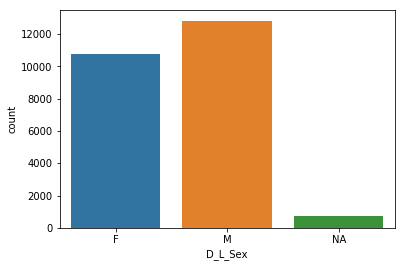

D_L_Eye ['Right' 'Left'] 2


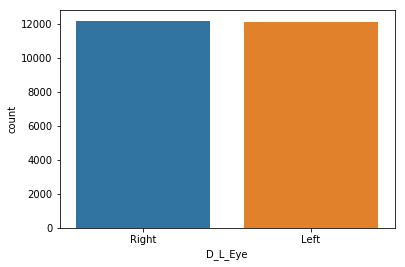

D_L_Dominant_Eye ['OD' 'OS' 'NA' 'ODS'] 4


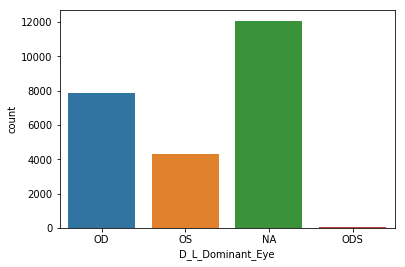

Pre_L_Contact_Lens ['Soft' 'None' 'NA' 'Hard'] 4


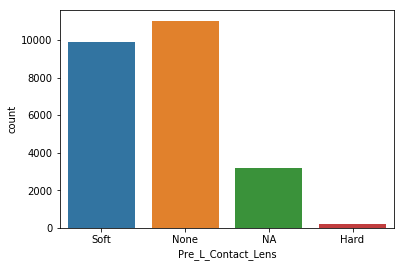

T_L_Laser_Type ['EX500' 'Alegreto' 'NA' 'LSX-NEW' '41'] 5


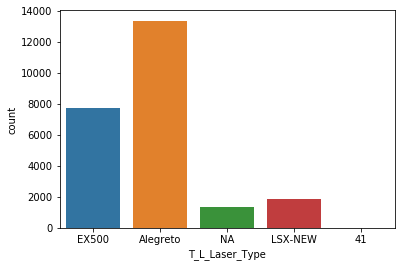

T_L_Treatment_Type ['Lasik' 'PRK LasEk'] 2


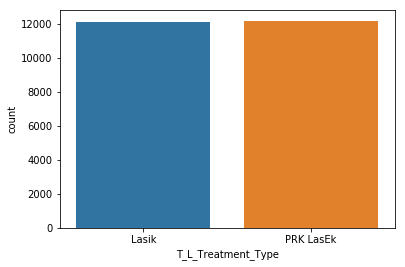

T_L_Cust_Ablation ['Wavefront Optimized' 'NA' 'T-Cat' 'Zioptic' 'A-Cat' 'No' 'TopoLink'] 7


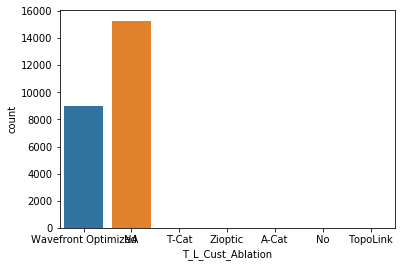

T_L_Micro ['Moria SBK' 'NA' 'Moria M2' '87'] 4


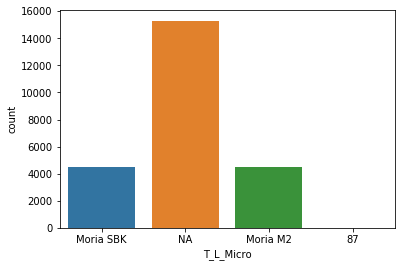

T_L_Head ['SBK-90' 'NA' 'SU90 +-10' 'SU2 90+-15' 'SU130 +-20'] 5


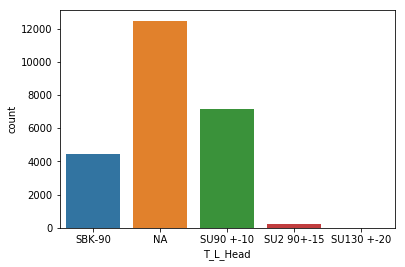

T_L_Therapeutic_Cont_L ['No' 'Yes' 'NA'] 3


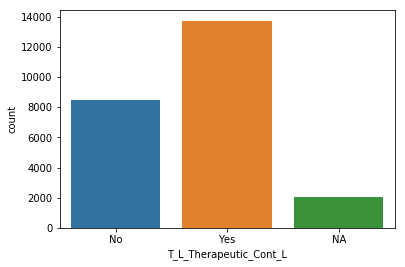

      D_L_Sex D_L_Eye D_L_Dominant_Eye Pre_L_Contact_Lens T_L_Laser_Type  \
16920       F   Right               OD               Soft          EX500   
16063       M   Right               OS               None          EX500   
8486        F   Right               NA               None       Alegreto   
18100       F   Right               OD               Soft          EX500   
17435       F   Right               NA               None       Alegreto   

      T_L_Treatment_Type    T_L_Cust_Ablation  T_L_Micro   T_L_Head  \
16920              Lasik  Wavefront Optimized  Moria SBK     SBK-90   
16063              Lasik  Wavefront Optimized  Moria SBK     SBK-90   
8486           PRK LasEk                   NA         NA         NA   
18100          PRK LasEk  Wavefront Optimized         NA         NA   
17435              Lasik                   NA   Moria M2  SU90 +-10   

      T_L_Therapeutic_Cont_L  
16920                     No  
16063                     No  
8486                   

In [22]:


for c in catcol:
    print(c,dftrain[c].unique(), len(dftrain[c].unique()))
    sns.countplot(data = dftrain, x = c)
    plt.show()
print(dftrain[dftrain.columns[categorical_mask]].head())



In [23]:


dftrain[catcol].info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 24289 entries, 16920 to 7791
Data columns (total 10 columns):
D_L_Sex                   24289 non-null object
D_L_Eye                   24289 non-null object
D_L_Dominant_Eye          24289 non-null object
Pre_L_Contact_Lens        24289 non-null object
T_L_Laser_Type            24289 non-null object
T_L_Treatment_Type        24289 non-null object
T_L_Cust_Ablation         24289 non-null object
T_L_Micro                 24289 non-null object
T_L_Head                  24289 non-null object
T_L_Therapeutic_Cont_L    24289 non-null object
dtypes: object(10)
memory usage: 2.7+ MB


   
### =============================================================================
### numeric_mask
### =============================================================================



In [24]:

numeric_mask = (dftrain.dtypes != object)
numeric_mask.Class=False
numcol=list(dftrain.columns[numeric_mask])

print(dftrain[numcol].info())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 24289 entries, 16920 to 7791
Data columns (total 33 columns):
D_L_Age                                  24289 non-null float64
D_L_From_this_Treat_until_last_Optalm    24289 non-null float64
Pre_L_Pupil_Night                        12866 non-null float64
Pre_L_Pachymetry                         22965 non-null float64
Pre_L_Average_K                          21272 non-null float64
Pre_L_K_Minimum                          18625 non-null float64
Pre_L_K_Maximum                          18636 non-null float64
Pre_L_Steep_Axis_max                     18361 non-null float64
Pre_L_Steep_Axis_min                     18438 non-null float64
Pre_L_Free_of_CL                         11969 non-null float64
Pre_L_Subjective_Sph                     24275 non-null float64
Pre_L_Subjective_Cyl                     23259 non-null float64
Pre_L_Spherical_Equivalence              24289 non-null float64
Pre_L_Subjective_Axis                    23349 non-null 

In [25]:

# =============================================================================
#  shayye
# =============================================================================

# =============================================================================
# logs
# =============================================================================
dftrain['LOG_D_L_From_this_Treat_until_last_Optalm']=np.log(1+ dftrain.D_L_From_this_Treat_until_last_Optalm )
dftrain['LOG_Pre_L_Free_of_CL']=np.log(1+ dftrain.Pre_L_Free_of_CL )
dftrain['LOG_T_L_Max_Abl_Depth']=np.log(1+ dftrain.T_L_Max_Abl_Depth )

dftestsubmision['LOG_D_L_From_this_Treat_until_last_Optalm']=np.log(1+ dftestsubmision.D_L_From_this_Treat_until_last_Optalm )
dftestsubmision['LOG_Pre_L_Free_of_CL']=np.log(1+ dftestsubmision.Pre_L_Free_of_CL )
dftestsubmision['LOG_T_L_Max_Abl_Depth']=np.log(1+ dftestsubmision.T_L_Max_Abl_Depth )



In [26]:

coltodel=['Pre_L_Pupil_Day']



In [27]:


from sklearn.mixture import GaussianMixture

def fixdata(data,colclass,num=0):
    samp0=np.copy(data)
    for i in range(len(colclass)):
        if colclass[i]==num:
            samp0[i]=np.nan
        else:
            samp0[i]=data[i]
    return samp0

def splitdata(dframe,dframetest,col):
    coldata=dframe[dframe[col].notna()][col].values
    coldata_test=dframetest[dframetest[col].notna()][col].values
    
    ind=dframe[dframe[col].notna()].index
    ind_test=dframetest[dframetest[col].notna()].index
    
    GM=GaussianMixture(n_components=2)
    col_class = GM.fit_predict(coldata.reshape(-1, 1))
    col_class_test=GM.predict(coldata_test.reshape(-1, 1))
    
    samp0=fixdata(coldata,col_class,0)
    samp1=fixdata(coldata,col_class,1)
    samp2=fixdata(coldata_test,col_class_test,0)
    samp3=fixdata(coldata_test,col_class_test,1)
    
    df0=pd.DataFrame(samp0,index=ind)
    df1=pd.DataFrame(samp1,index=ind)
    df2=pd.DataFrame(samp2,index=ind_test)
    df3=pd.DataFrame(samp3,index=ind_test)
    
    return df0,df1,df2,df3



In [29]:
   
dftrain['Pre_L_Subjective_Axis0'],dftrain['Pre_L_Subjective_Axis1'],dftestsubmision['Pre_L_Subjective_Axis0'],dftestsubmision['Pre_L_Subjective_Axis1']=splitdata(dftrain,dftestsubmision,'Pre_L_Subjective_Axis')
dftrain['Pre_L_Steep_Axis_min0'],dftrain['Pre_L_Steep_Axis_min1'],dftestsubmision['Pre_L_Steep_Axis_min0'],dftestsubmision['Pre_L_Steep_Axis_min1']=splitdata(dftrain,dftestsubmision,'Pre_L_Steep_Axis_min')
#dftrain['Pre_L_Cycloplegia_Axis0'],dftrain['Pre_L_Cycloplegia_Axis1'],dftestsubmision['Pre_L_Cycloplegia_Axis0'],dftestsubmision['Pre_L_Cycloplegia_Axis1']=splitdata(dftrain,dftestsubmision,'Pre_L_Cycloplegia_Axis')
dftrain['T_L_Treatment_ZO0'],dftrain['T_L_Treatment_ZO1'],dftestsubmision['T_L_Treatment_ZO0'],dftestsubmision['T_L_Treatment_ZO1']=splitdata(dftrain,dftestsubmision,'T_L_Treatment_ZO')
dftrain['T_L_Stop0'],dftrain['T_L_Stop1'],dftestsubmision['T_L_Stop0'],dftestsubmision['T_L_Stop1']=splitdata(dftrain,dftestsubmision,'T_L_Stop')



In [44]:

colmean=['Pre_L_Subjective_Axis0','Pre_L_Steep_Axis_min0','Pre_L_Steep_Axis_min1',
         'T_L_Treatment_ZO0','T_L_Treatment_ZO1',
         'T_L_Stop0','T_L_Stop1']



In [35]:

# =============================================================================
# quantile - not need for test
# =============================================================================
dftrain=dftrain[np.logical_or(dftrain.T_L_Treatment_Param_Cyl<=dftrain.T_L_Treatment_Param_Cyl.quantile(0.99),dftrain.T_L_Treatment_Param_Cyl.isna())]
dftrain=dftrain[np.logical_or(dftrain.Pre_L_Average_K>=dftrain.Pre_L_Average_K.quantile(0.01),dftrain.Pre_L_Average_K.isna())]
dftrain=dftrain[np.logical_or(dftrain.Pre_L_Subjective_Cyl>=dftrain.Pre_L_Subjective_Cyl.quantile(0.01),dftrain.Pre_L_Subjective_Cyl.isna())]
#dftrain=dftrain[np.logical_or(dftrain.Pre_L_Cycloplegia_Cyl>dftrain.Pre_L_Cycloplegia_Cyl.quantile(0.01),dftrain.Pre_L_Cycloplegia_Cyl.isna())]
dftrain=dftrain[np.logical_or(dftrain.T_L_Treatment_Param_Axis<=dftrain.T_L_Treatment_Param_Axis.quantile(0.99),dftrain.T_L_Treatment_Param_Axis.isna())]
dftrain=dftrain[np.logical_or(dftrain.T_L_Opt_Zo>=dftrain.T_L_Opt_Zo.quantile(0.01),dftrain.T_L_Opt_Zo.isna())]
#dftrain=dftrain[np.logical_or(dftrain.T_L_PTK_mmm>=dftrain.T_L_PTK_mmm.quantile(0.01),dftrain.T_L_PTK_mmm.isna())]
dftrain=dftrain[np.logical_or(dftrain.Pre_L_Est_BCVA>=dftrain.Pre_L_Est_BCVA.quantile(0.01),dftrain.Pre_L_Est_BCVA.isna())]
dftrain=dftrain[np.logical_or(dftrain.T_L_MZ<=dftrain.T_L_MZ.quantile(0.99),dftrain.T_L_MZ.isna())]



In [36]:

for c in numcol:
    print('\n')
    print(dftrain[c].describe().count)





<bound method Series.count of count    22164.000000
mean        26.075934
std          5.788521
min         18.000000
25%         21.000000
50%         25.000000
75%         30.000000
max         40.000000
Name: D_L_Age, dtype: float64>


<bound method Series.count of count    22164.000000
mean       170.315151
std        361.908112
min          4.000000
25%         39.000000
50%         93.000000
75%        137.000000
max       4544.000000
Name: D_L_From_this_Treat_until_last_Optalm, dtype: float64>


<bound method Series.count of count    11790.000000
mean         6.118533
std          0.926810
min          0.000000
25%          5.700000
50%          6.000000
75%          6.500000
max         11.900000
Name: Pre_L_Pupil_Night, dtype: float64>


<bound method Series.count of count    20909.000000
mean       535.203979
std         35.472471
min        253.000000
25%        512.000000
50%        535.000000
75%        559.000000
max        687.000000
Name: Pre_L_Pachymetry, dtype: floa

In [37]:

numeric_mask = (dftrain.dtypes != object)
numeric_mask.Class=False
numcol=list(dftrain.columns[numeric_mask])

for x in numcol:
    print(x,dftrain[x].unique(), len(dftrain[x].unique()))
    


D_L_Age [34. 24. 20. 38. 30. 21. 23. 18. 25. 39. 22. 32. 33. 27. 19. 40. 26. 31.
 35. 29. 36. 28. 37.] 23
D_L_From_this_Treat_until_last_Optalm [  47.   29. 1504. ... 3651. 1900. 1066.] 1310
Pre_L_Pupil_Night [ 6.   nan  7.5  5.   5.6  6.5  8.   7.   5.5  9.   4.5  5.4  4.   5.7
  3.5  3.6  4.8  5.3  4.4  4.9  5.1  3.4  3.9  7.8  6.2  3.7  4.2  3.
  7.7  5.2  4.3  7.2  5.8  6.6  4.6  6.3  6.8  3.8  6.4  8.5  5.9 10.
  0.   7.1  6.7 11.9  3.2  2.7  7.9  6.9  6.1  4.7  7.6  8.2  9.5  2.5
  4.1  2.6  8.8  7.4  7.3  9.8  8.6] 63
Pre_L_Pachymetry [495. 585. 496. 569. 523.  nan 552. 547. 560. 548. 493. 581. 516. 527.
 536. 529. 518. 526. 576. 574. 551. 537. 455. 489. 498. 503. 590. 512.
 565. 538. 578. 556. 539. 583. 505. 549. 533. 582. 517. 530. 507. 472.
 554. 550. 570. 490. 494. 593. 558. 559. 513. 521. 572. 510. 588. 553.
 566. 596. 580. 515. 584. 499. 525. 511. 488. 535. 501. 546. 562. 514.
 598. 587. 573. 557. 506. 594. 519. 567. 575. 522. 450. 504. 563. 479.
 542. 615. 591. 540. 509. 

In [38]:


for c in numcol:
    print('\n')
    print(dftrain[c].describe().count)





<bound method Series.count of count    22164.000000
mean        26.075934
std          5.788521
min         18.000000
25%         21.000000
50%         25.000000
75%         30.000000
max         40.000000
Name: D_L_Age, dtype: float64>


<bound method Series.count of count    22164.000000
mean       170.315151
std        361.908112
min          4.000000
25%         39.000000
50%         93.000000
75%        137.000000
max       4544.000000
Name: D_L_From_this_Treat_until_last_Optalm, dtype: float64>


<bound method Series.count of count    11790.000000
mean         6.118533
std          0.926810
min          0.000000
25%          5.700000
50%          6.000000
75%          6.500000
max         11.900000
Name: Pre_L_Pupil_Night, dtype: float64>


<bound method Series.count of count    20909.000000
mean       535.203979
std         35.472471
min        253.000000
25%        512.000000
50%        535.000000
75%        559.000000
max        687.000000
Name: Pre_L_Pachymetry, dtype: floa

In [39]:


dftrain[numcol].info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 22164 entries, 16920 to 7791
Data columns (total 44 columns):
D_L_Age                                      22164 non-null float64
D_L_From_this_Treat_until_last_Optalm        22164 non-null float64
Pre_L_Pupil_Night                            11790 non-null float64
Pre_L_Pachymetry                             20909 non-null float64
Pre_L_Average_K                              19310 non-null float64
Pre_L_K_Minimum                              17094 non-null float64
Pre_L_K_Maximum                              17105 non-null float64
Pre_L_Steep_Axis_max                         16856 non-null float64
Pre_L_Steep_Axis_min                         16924 non-null float64
Pre_L_Free_of_CL                             11271 non-null float64
Pre_L_Subjective_Sph                         22160 non-null float64
Pre_L_Subjective_Cyl                         21183 non-null float64
Pre_L_Spherical_Equivalence                  22164 non-null float64
Pre_

In [40]:


# =============================================================================
# bak data
# =============================================================================

def bak_df(train,test,submision):
    return train.copy(),test.copy(),submision.copy()

def load_bak(train_bak,test_bak,testsubmision_bak):
    return train_bak.copy(),test_bak.copy(),testsubmision_bak.copy()



In [41]:

# =============================================================================
# bak df
# =============================================================================
train_bak,test_bak,dftestsubmision_bak=bak_df(dftrain,dftest,dftestsubmision)




In [ ]:

# =============================================================================
# reset from bak
# =============================================================================
dftrain,dftest,dftestsubmision=load_bak(train_bak,test_bak,dftestsubmision_bak)



In [42]:


li=list(dftrain.columns)
li.append(li.pop(li.index('Class')))
dftrain=dftrain[li]
#dftest=dftest[li]
dftestsubmision=dftestsubmision[li]

numeric_mask = (dftrain.dtypes != object)
numeric_mask.Class=False
numcol=list(dftrain.columns[numeric_mask])

categorical_mask = (dftrain.dtypes == object)
catcol=list(dftrain.columns[categorical_mask])


In [45]:


dftrain[colmean]=dftrain[colmean].fillna(0)
#dftest[catcol]=dftest[catcol].fillna(0)
dftestsubmision[colmean]=dftestsubmision[colmean].fillna(0)


In [46]:

## =============================================================================
## normilize data
## =============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
#numcol=list(dftrain.columns[numeric_mask])

scaler = StandardScaler()

dftrain[numcol]=scaler.fit_transform(dftrain[numcol])   
#dftest[numcol]=scaler.transform(dftest[numcol])
dftestsubmision[numcol]=scaler.transform(dftestsubmision[numcol])



C:\Users\mor\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [47]:

# =============================================================================
# impute nan values
# =============================================================================

numeric_mask=dftrain.dtypes=='float64'
numeric_mask.Class=False


In [48]:

from sklearn.impute import SimpleImputer
numcol=list(dftrain.columns[numeric_mask])
#median,mean,most_frequent
impmean = SimpleImputer(missing_values=np.nan, strategy='mean')
impmode = SimpleImputer(missing_values=np.nan, strategy='median') 


dftrain[colmean]=impmean.fit_transform(dftrain[colmean])  
##dftest[numcol]=imp.transform(dftest[numcol]) 
dftestsubmision[colmean]=impmean.transform(dftestsubmision[colmean])  

dftrain[numcol]=impmode.fit_transform(dftrain[numcol])  
#dftest[numcol]=imp.transform(dftest[numcol]) 
dftestsubmision[numcol]=impmode.transform(dftestsubmision[numcol])  
 


In [49]:


dftrain[numcol].info()
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 22164 entries, 16920 to 7791
Data columns (total 44 columns):
D_L_Age                                      22164 non-null float64
D_L_From_this_Treat_until_last_Optalm        22164 non-null float64
Pre_L_Pupil_Night                            22164 non-null float64
Pre_L_Pachymetry                             22164 non-null float64
Pre_L_Average_K                              22164 non-null float64
Pre_L_K_Minimum                              22164 non-null float64
Pre_L_K_Maximum                              22164 non-null float64
Pre_L_Steep_Axis_max                         22164 non-null float64
Pre_L_Steep_Axis_min                         22164 non-null float64
Pre_L_Free_of_CL                             22164 non-null float64
Pre_L_Subjective_Sph                         22164 non-null float64
Pre_L_Subjective_Cyl                         22164 non-null float64
Pre_L_Spherical_Equivalence                  22164 non-null float64
Pre_

In [50]:

# =============================================================================
# handle categories data
# =============================================================================
import category_encoders as ce

catcol=list(dftrain.columns[categorical_mask])

encoder = ce.BinaryEncoder(drop_invariant=True,cols=catcol)

dftrain = encoder.fit_transform(dftrain)
#dftest = encoder.transform(dftest)
dftestsubmision = encoder.transform(dftestsubmision)


In [51]:



dftrain['new1T_L_Alchohol']=dftrain.T_L_Alchohol*dftrain.T_L_Alchohol
dftrain['new0T_L_Alchohol']=dftrain.T_L_Alchohol*dftrain.D_L_Age
dftrain['new2T_L_Alchohol']=dftrain.T_L_Alchohol*dftrain.T_L_Max_Abl_Depth
dftrain['new3T_L_Alchohol']=dftrain.T_L_Alchohol*dftrain.Pre_L_Subjective_Cyl
dftrain['new4T_L_Alchohol']=dftrain.T_L_Alchohol*dftrain.T_L_Target_SE
dftrain['new5T_L_Alchohol']=dftrain.T_L_Alchohol*dftrain.T_L_Treatment_Param_Cyl
dftrain['new6T_L_Alchohol']=dftrain.T_L_Alchohol*dftrain.D_L_Dominant_Eye_1
dftrain['new7T_L_Alchohol']=dftrain.T_L_Alchohol*dftrain.T_L_Treatment_Type_1
dftrain['new6T_L_Max_Abl_Depth']=dftrain.T_L_Max_Abl_Depth*dftrain.Pre_L_Subjective_Cyl
dftrain['new7T_L_Max_Abl_Depth']=dftrain.T_L_Max_Abl_Depth*dftrain.T_L_Target_SE
dftrain['new8T_L_Max_Abl_Depth']=dftrain.T_L_Max_Abl_Depth*dftrain.T_L_Treatment_Param_Cyl
dftrain['new9T_L_Max_Abl_Depth']=dftrain.T_L_Max_Abl_Depth*dftrain.D_L_Age
dftrain['new10Pre_L_Steep_Axis_max']=dftrain.Pre_L_Steep_Axis_max*dftrain.D_L_Dominant_Eye_2
dftrain['new11Pre_L_Steep_Axis_max']=dftrain.Pre_L_Steep_Axis_max*dftrain.T_L_Alchohol
dftrain['new12Pre_L_Steep_Axis_max']=dftrain.Pre_L_Steep_Axis_max*dftrain.D_L_Eye_0
dftrain['new13Pre_L_Est_BCVA']=dftrain.Pre_L_Est_BCVA*dftrain.Pre_L_Pachymetry
dftrain['new14Pre_L_Est_BCVA']=dftrain.Pre_L_Est_BCVA*dftrain.D_L_Dominant_Eye_1
dftrain['new15Pre_L_Est_BCVA']=dftrain.Pre_L_Est_BCVA*dftrain.D_L_Eye_1


#dftest['new1T_L_Alchohol']=dftest.T_L_Alchohol*dftest.T_L_Alchohol
#dftest['new0T_L_Alchohol']=dftest.T_L_Alchohol*dftest.D_L_Age
#dftest['new2T_L_Alchohol']=dftest.T_L_Alchohol*dftest.T_L_Max_Abl_Depth
#dftest['new3T_L_Alchohol']=dftest.T_L_Alchohol*dftest.Pre_L_Subjective_Cyl
#dftest['new4T_L_Alchohol']=dftest.T_L_Alchohol*dftest.T_L_Target_SE
#dftest['new5T_L_Alchohol']=dftest.T_L_Alchohol*dftest.T_L_Treatment_Param_Cyl
#dftest['new6T_L_Alchohol']=dftest.T_L_Alchohol*dftest.D_L_Dominant_Eye_1
#dftest['new7T_L_Alchohol']=dftest.T_L_Alchohol*dftest.T_L_Treatment_Type_1
#dftest['new6T_L_Max_Abl_Depth']=dftest.T_L_Max_Abl_Depth*dftest.Pre_L_Subjective_Cyl
#dftest['new7T_L_Max_Abl_Depth']=dftest.T_L_Max_Abl_Depth*dftest.T_L_Target_SE
#dftest['new8T_L_Max_Abl_Depth']=dftest.T_L_Max_Abl_Depth*dftest.T_L_Treatment_Param_Cyl
#dftest['new9T_L_Max_Abl_Depth']=dftest.T_L_Max_Abl_Depth*dftest.D_L_Age
#dftest['new10Pre_L_Steep_Axis_max']=dftest.Pre_L_Steep_Axis_max*dftest.D_L_Dominant_Eye_2
#dftest['new11Pre_L_Steep_Axis_max']=dftest.Pre_L_Steep_Axis_max*dftest.T_L_Alchohol
#dftest['new12Pre_L_Steep_Axis_max']=dftest.Pre_L_Steep_Axis_max*dftest.D_L_Eye_0
#dftest['new13Pre_L_Est_BCVA']=dftest.Pre_L_Est_BCVA*dftest.Pre_L_Pachymetry
#dftest['new14Pre_L_Est_BCVA']=dftest.Pre_L_Est_BCVA*dftest.D_L_Dominant_Eye_1
#dftest['new15Pre_L_Est_BCVA']=dftest.Pre_L_Est_BCVA*dftest.D_L_Eye_1




dftestsubmision['new1T_L_Alchohol']=dftestsubmision.T_L_Alchohol*dftestsubmision.T_L_Alchohol
dftestsubmision['new0T_L_Alchohol']=dftestsubmision.T_L_Alchohol*dftestsubmision.D_L_Age
dftestsubmision['new2T_L_Alchohol']=dftestsubmision.T_L_Alchohol*dftestsubmision.T_L_Max_Abl_Depth
dftestsubmision['new3T_L_Alchohol']=dftestsubmision.T_L_Alchohol*dftestsubmision.Pre_L_Subjective_Cyl
dftestsubmision['new4T_L_Alchohol']=dftestsubmision.T_L_Alchohol*dftestsubmision.T_L_Target_SE
dftestsubmision['new5T_L_Alchohol']=dftestsubmision.T_L_Alchohol*dftestsubmision.T_L_Treatment_Param_Cyl
dftestsubmision['new6T_L_Alchohol']=dftestsubmision.T_L_Alchohol*dftestsubmision.D_L_Dominant_Eye_1
dftestsubmision['new7T_L_Alchohol']=dftestsubmision.T_L_Alchohol*dftestsubmision.T_L_Treatment_Type_1
dftestsubmision['new6T_L_Max_Abl_Depth']=dftestsubmision.T_L_Max_Abl_Depth*dftestsubmision.Pre_L_Subjective_Cyl
dftestsubmision['new7T_L_Max_Abl_Depth']=dftestsubmision.T_L_Max_Abl_Depth*dftestsubmision.T_L_Target_SE
dftestsubmision['new8T_L_Max_Abl_Depth']=dftestsubmision.T_L_Max_Abl_Depth*dftestsubmision.T_L_Treatment_Param_Cyl
dftestsubmision['new9T_L_Max_Abl_Depth']=dftestsubmision.T_L_Max_Abl_Depth*dftestsubmision.D_L_Age
dftestsubmision['new10Pre_L_Steep_Axis_max']=dftestsubmision.Pre_L_Steep_Axis_max*dftestsubmision.D_L_Dominant_Eye_2
dftestsubmision['new11Pre_L_Steep_Axis_max']=dftestsubmision.Pre_L_Steep_Axis_max*dftestsubmision.T_L_Alchohol
dftestsubmision['new12Pre_L_Steep_Axis_max']=dftestsubmision.Pre_L_Steep_Axis_max*dftestsubmision.D_L_Eye_0
dftestsubmision['new13Pre_L_Est_BCVA']=dftestsubmision.Pre_L_Est_BCVA*dftestsubmision.Pre_L_Pachymetry
dftestsubmision['new14Pre_L_Est_BCVA']=dftestsubmision.Pre_L_Est_BCVA*dftestsubmision.D_L_Dominant_Eye_1
dftestsubmision['new15Pre_L_Est_BCVA']=dftestsubmision.Pre_L_Est_BCVA*dftestsubmision.D_L_Eye_1




In [52]:

li=list(dftrain.columns)
li.append(li.pop(li.index('Class')))
dftrain=dftrain[li]
#dftest=dftest[li]
dftestsubmision=dftestsubmision[li]

numeric_mask = (dftrain.dtypes != object)
numeric_mask.Class=False
numcol=list(dftrain.columns[numeric_mask])

categorical_mask = (dftrain.dtypes == object)
catcol=list(dftrain.columns[categorical_mask])



In [53]:

## =============================================================================
## normilize data
## =============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
numcol=list(dftrain.columns[numeric_mask])

scaler = StandardScaler()

dftrain[numcol]=scaler.fit_transform(dftrain[numcol])   
#dftest[numcol]=scaler.transform(dftest[numcol])
dftestsubmision[numcol]=scaler.transform(dftestsubmision[numcol])



C:\Users\mor\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mor\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mor\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [54]:

# =============================================================================
# drop correlation features 
# =============================================================================
# Create correlation matrix
corr_matrix = dftrain.iloc[:,:-1].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
print(to_drop)


['D_L_Eye_1', 'T_L_Treatment_Type_1', 'T_L_Cust_Ablation_3', 'new7T_L_Alchohol']


In [55]:

dftrain.drop(to_drop,axis=1)
dftestsubmision.drop(to_drop,axis=1)




,D_L_Sex_1,D_L_Sex_2,D_L_Eye_0,D_L_Dominant_Eye_0,D_L_Dominant_Eye_1,D_L_Dominant_Eye_2,Pre_L_Contact_Lens_0,Pre_L_Contact_Lens_1,Pre_L_Contact_Lens_2,T_L_Laser_Type_1,...,new7T_L_Max_Abl_Depth,new8T_L_Max_Abl_Depth,new9T_L_Max_Abl_Depth,new10Pre_L_Steep_Axis_max,new11Pre_L_Steep_Axis_max,new12Pre_L_Steep_Axis_max,new13Pre_L_Est_BCVA,new14Pre_L_Est_BCVA,new15Pre_L_Est_BCVA,Class
0,0.905705,-0.960099,1.004975,-0.030796,-1.425341,-2.149675,-0.090992,0.865399,-1.091124,-0.240093,...,-0.375109,0.238842,0.371791,-0.001282,-0.120186,-1.489567,-1.262708,-0.003087,-0.001375,0
1,0.905705,-0.960099,1.004975,-0.030796,0.701587,-2.149675,-0.090992,0.865399,-1.091124,-0.240093,...,0.112767,0.474053,0.192886,-0.001282,0.073002,0.925659,0.286414,0.630035,-0.001375,0
2,-1.104112,1.041560,1.004975,-0.030796,-1.425341,-2.149675,-0.090992,0.865399,0.916486,4.165055,...,0.359861,-0.108037,-2.031247,-0.001282,-0.004273,-0.040432,0.028227,-0.003087,-0.001375,0
3,-1.104112,1.041560,1.004975,-0.030796,-1.425341,0.465187,-0.090992,0.865399,-1.091124,-0.240093,...,-0.219020,0.241522,0.221230,0.395012,0.034364,0.442613,0.195289,-0.003087,-0.001375,0
4,-1.104112,1.041560,-0.995049,-0.030796,0.701587,-2.149675,-0.090992,0.865399,-1.091124,-0.240093,...,-0.381113,0.048373,0.297262,-0.001282,0.030071,-0.061899,0.559789,0.630035,0.731655,0
5,0.905705,-0.960099,1.004975,-0.030796,-1.425341,-2.149675,-0.090992,-1.155537,0.916486,-0.240093,...,-7.206505,-0.949143,0.474669,-0.001282,0.004313,0.066912,-0.214772,-0.003087,-0.001375,0
6,-1.104112,1.041560,-0.995049,-0.030796,-1.425341,-2.149675,-0.090992,-1.155537,0.916486,-0.240093,...,-0.098142,0.073398,0.238854,-0.001282,0.081588,-0.061899,1.228038,-0.003087,0.731655,0
7,-1.104112,1.041560,-0.995049,-0.030796,-1.425341,-2.149675,-0.090992,0.865399,0.916486,4.165055,...,-0.310090,0.286116,-0.967317,-0.001282,-0.004273,-0.061899,0.286414,-0.003087,0.731655,0
8,-1.104112,1.041560,-0.995049,-0.030796,-1.425341,-2.149675,-0.090992,-1.155537,0.916486,-0.240093,...,-0.423316,0.048373,0.297262,-0.001282,-0.012859,-0.061899,-0.229960,-0.003087,0.731655,0
9,-1.104112,1.041560,-0.995049,-0.030796,-1.425341,-2.149675,10.990005,-1.155537,-1.091124,-0.240093,...,-0.441218,0.217295,-0.466138,-0.001282,-0.004273,-0.061899,0.456948,-0.003087,-0.294031,0


In [ ]:

## =============================================================================
## add new features
## =============================================================================
#X=dftrain.iloc[:,:-1].values
#X_sub=dftestsubmision.iloc[:,:-1].values
#
#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree=2, interaction_only=True)
#Xnew = poly.fit_transform(X) 
#X_sub_new=poly.transform(X_sub)
#
#

In [ ]:

#
#li=list(dftrain.columns)
#li.append(li.pop(li.index('Class')))
#dftrain=dftrain[li]
##dftest=dftest[li]
#dftestsubmision=dftestsubmision[li]
#
#numeric_mask = (dftrain.dtypes != object)
#numeric_mask.Class=False
#numcol=list(dftrain.columns[numeric_mask])
#
#categorical_mask = (dftrain.dtypes == object)
#catcol=list(dftrain.columns[categorical_mask])



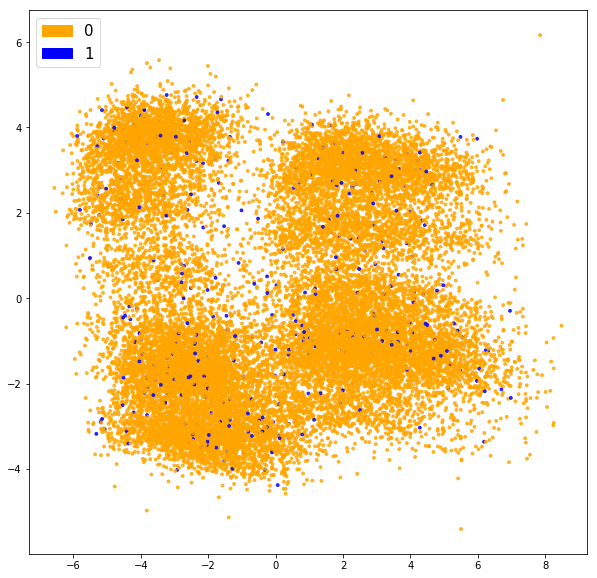

In [56]:

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
#        
#        tsne = TSNE(perplexity=30.0, n_components=2, init='pca', n_iter=1000)
#        lsa_scores = tsne.fit_transform(test_data)    
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)

        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='0')
            green_patch = mpatches.Patch(color='blue', label='1')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 15})


fig = plt.figure(figsize=(10, 10))          
plot_LSA(dftrain.iloc[:,:-1].values, dftrain.iloc[:,-1].values)
plt.show()






### =============================================================================
### **************** models ****************
### =============================================================================



In [57]:



# =============================================================================
# **************** random forest resample ****************
# =============================================================================




In [58]:


def tuneParameter(grid):
    param={}
    for key,val in grid.items():
        param[key]=np.random.choice(val)
    return param




In [59]:

#gbm
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depth = np.linspace(1, 32, 32, endpoint=True)
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features = ['auto', 'log2',None]


random_grid = {'learning_rate':learning_rate,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)



{'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01], 'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 'max_features': ['auto', 'log2', None], 'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32.]), 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5])}


In [60]:

#rf
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
#criterion type
criterion =['gini','entropy']
# Number of features to consider at every split
max_features = ['auto', 'log2',None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'criterion':criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)



{'criterion': ['gini', 'entropy'], 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'log2', None], 'max_depth': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [61]:

#tree   
#criterion type
criterion =['gini','entropy']
# Number of features to consider at every split
max_features = ['auto', 'log2',None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'criterion':criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]




In [62]:

tree = DecisionTreeClassifier()
tree.set_params(**tuneParameter(random_grid))


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [64]:

        
param = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'gamma':[i/10.0 for i in range(0,5)],
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 'learning_rate' :[0.01,0.1,1],
 'n_estimators' : [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],
 'scale_pos_weight' : [1,2,3,4,5,6,7,8,9,10]
 
}
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
        


In [ ]:

from sklearn.ensemble import GradientBoostingClassifier
from resample_forest import ResampleForestClassifier
bestauc_down=0
bestauc_up=0
X, y = dftrain.iloc[:,:-1].values,dftrain.iloc[:,-1].values
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
for num in range(50):
    np.random.seed(num)
    print(' ************************************ ',num)
    numOfest=np.random.choice(n_estimators)
    rf=RandomForestClassifier(random_state=0, n_jobs=-1)
    rf.set_params(**tuneParameter(random_grid))
    aucs_down=[]
    aucs_up=[]
    for train_index, test_index in kfold.split(X,y):
        dftraincv, dftestcv = dftrain.iloc[train_index], dftrain.iloc[test_index]
        ros = RandomOverSampler(random_state=42)
        X_res, y_res=ros.fit_resample(dftraincv.iloc[:,:-1].values,dftraincv.iloc[:,-1].values)
#        rf_dn = ResampleForestClassifier(gbm, n_estimators=numOfest, sampling='down', random_state=0, n_jobs=-1 , verbose=False)
#        rf_up = ResampleForestClassifier(tree, n_estimators=numOfest, sampling='up', n_jobs=-1, random_state=0, verbose=False)
#        rf_dn.fit(dftraincv.iloc[:,:-1].values,dftraincv.iloc[:,-1].values)
        rf.fit(X_res, y_res)
        print(123)
#        rf_up.fit(dftraincv.iloc[:,:-1].values,dftraincv.iloc[:,-1].values)
        print(456)
        aucs_down.append(metrics.roc_auc_score(dftestcv.iloc[:,-1].values, rf.predict_proba(dftestcv.iloc[:,:-1].values)[:,1]))
#        aucs_up.append(metrics.roc_auc_score(dftestcv.iloc[:,-1].values, rf_up.predict(dftestcv.iloc[:,:-1].values)))
        print(aucs_down)
    avgauc_down=np.array(aucs_down).mean()
#    avgauc_up=np.array(aucs_up).mean()
    if bestauc_down<avgauc_down:
        besttree_down=rf    
        best_n_down=numOfest
        bestauc_down=avgauc_down
#    if bestauc_up<avgauc_up:
#        bestTree_up=tree    
#        best_n_up=numOfest
#        bestauc_up=avgauc_up
    print(bestauc_down)
#    print(besttree_down)
#    print(best_n_down)


In [ ]:

    
#rf best
rf=RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

X_res, y_res=ros.fit_resample(dftrain.iloc[:,:-1].values,dftrain.iloc[:,-1].values)
rf.fit(X_res, y_res)


In [ ]:

y_pred=rf.predict_proba(X_res)[:,1]
print("roc_auc:",metrics.roc_auc_score(y_res, y_pred))



In [ ]:


sub_prob=rf.predict_proba(dftestsubmision.iloc[:,:-1].values)[:,1]
  


In [ ]:

        
from resample_forest import ResampleForestClassifier
from collections import OrderedDict

rfc=RandomForestClassifier(n_estimators=250)
svm=SVC(probability=True)


tree = DecisionTreeClassifier()

rf_up = ResampleForestClassifier(tree, n_estimators=10, sampling='up', random_state=0, verbose=False)


In [ ]:

rf_dn = ResampleForestClassifier(tree, n_estimators=10, sampling='down', random_state=0 , verbose=False)


In [ ]:

X, y = dftrain.iloc[:,:-1].values,dftrain.iloc[:,-1].values



In [ ]:

# =============================================================================
# compare between random forest types
# =============================================================================
cv = StratifiedKFold(n_splits=5)
labels = ['up-sampling', 'down-sampling']
clfs = [rf_up, rf_dn]

aurocs = OrderedDict()
for i in range(len(clfs)):
    clf = clfs[i]
    aurocs[labels[i]] = cross_val_score(clf, X, y, scoring='roc_auc', cv=cv)

aurocs = pd.DataFrame(aurocs)
    
sns.boxplot(data=aurocs)
plt.ylabel('CV AUCROC')
plt.tight_layout()
plt.show()



In [ ]:

rf_dn.fit(X,y)



In [ ]:


y_pred=rf_dn.predict(X)
print("roc_auc:",metrics.roc_auc_score(dftrain.iloc[:,-1].values, y_pred))



In [ ]:


sub_prob=rf_dn.predict_proba(dftestsubmision.iloc[:,:-1].values)[:,1]



In [66]:


# =============================================================================
# ************** Imbalance Classifier **************
# =============================================================================



In [ ]:

#rusboost - Random under-sampling integrating in the learning of an AdaBoost classifier.
algorithm=['SAMME', 'SAMME.R']
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
learning_rate=[0.001,0.01,0.1,1]
sampling_strategy=['majority','not minority','not majority','all']
replacement=[True,False]

grid= {'algorithm':algorithm,
               'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'sampling_strategy': sampling_strategy,
               'replacement': replacement}
print(grid)


In [ ]:

#bbc - A Bagging classifier with additional balancing
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
bootstrap=[True,False]
bootstrap_features=[True,False] 
max_features=[0.6,0.7,0.8,0.9,1.0]
max_samples=[0.6,0.7,0.8,0.9,1.0]
oob_score=[True,False]
sampling_strategy=['majority','not minority','not majority','all'] 
replacement=[True,False]            

grid={'n_estimators':n_estimators,
#      'bootstrap':bootstrap,
      'bootstrap_features':bootstrap_features,
      'max_features':max_features,
      'max_samples':max_samples,
      'oob_score':oob_score,
      'sampling_strategy':sampling_strategy,
      'replacement':replacement
      }             
print(grid)



In [ ]:

#brf - A balanced random forest classifier
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
criterion =['gini','entropy']
max_features = ['auto', 'log2',None]
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
sampling_strategy=['majority','not minority','not majority','all'] 

random_grid = {'criterion':criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'sampling_strategy':sampling_strategy}
print(random_grid)



In [ ]:

#easy ens - Create an ensemble sets by iteratively applying random under-sampling.
n_estimators = [int(x) for x in np.linspace(start = 10 , stop = 100, num = 10)]
sampling_strategy=['majority','not minority','not majority','all'] 
replacement=[True,False]

grid={'n_estimators':n_estimators,
      'sampling_strategy':sampling_strategy,
      'replacement':replacement
      }


In [ ]:

from imblearn.ensemble import RUSBoostClassifier,BalancedBaggingClassifier ,BalancedRandomForestClassifier ,EasyEnsembleClassifier
rusboost = RUSBoostClassifier(random_state=0)
bbc = BalancedBaggingClassifier(random_state=0)
brf = BalancedRandomForestClassifier(sampling_strategy='all',min_samples_leaf= 4,n_estimators=300,
                                     min_samples_split= 2, max_features=None,max_depth=4, criterion='entropy',
                                     bootstrap=True,random_state=0)
#ens=EasyEnsembleClassifier(random_state=0)



In [ ]:

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=4) 
rf_random = RandomizedSearchCV(estimator = bbc, param_distributions = grid, n_iter = 50, cv = kfold, n_jobs=-1,
                                       verbose=2, random_state=0,scoring='roc_auc')
X=dftrain.iloc[:,:-1].values
y=dftrain.iloc[:,-1].values


In [ ]:


rf_random.fit(X,y)



In [ ]:


print(rf_random.best_score_)
print(rf_random.best_params_)



In [ ]:


sub=rf_random.predict_proba(dftestsubmision.iloc[:,:-1].values)[:,1]



In [ ]:

# =============================================================================
# train after cross validation 
# =============================================================================



In [ ]:


#best settings
bbc = BalancedBaggingClassifier(sampling_strategy='majority',replacement=False,oob_score=True,
                                n_estimators=500,max_samples=0.9,max_features=0.8,bootstrap_features=False,random_state=0)
bbc.fit(X,y)



In [ ]:


#best settings
rusboost = RUSBoostClassifier(random_state=0, sampling_strategy='majority', replacement= False, 
                              n_estimators= 350, learning_rate= 0.001, algorithm= 'SAMME')
rusboost.fit(X,y)



In [ ]:

#best settings
brf = BalancedRandomForestClassifier(sampling_strategy='majority',min_samples_leaf= 2,n_estimators=150,
                                     min_samples_split= 2, max_features=None,max_depth=6, criterion='entropy',
                                     bootstrap=False,random_state=0)
brf.fit(X,y)



In [ ]:

#best settings2
brf = BalancedRandomForestClassifier(sampling_strategy='all',min_samples_leaf= 4,n_estimators=300,
                                     min_samples_split= 2, max_features=None,max_depth=4, criterion='entropy',
                                     bootstrap=False,random_state=0)
brf.fit(X,y)



In [ ]:

###pickle best
brf = BalancedRandomForestClassifier(sampling_strategy='not minority',min_samples_leaf= 2,n_estimators=450,
                                     min_samples_split= 10, max_features=None,max_depth=4, criterion='entropy',
                                     bootstrap=False,random_state=0)
brf.fit(X,y)




In [ ]:

# =============================================================================
# compare between balance types
# =============================================================================
besttree=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

brf = BalancedRandomForestClassifier(sampling_strategy='not minority',min_samples_leaf= 2,n_estimators=450,
                                     min_samples_split= 10, max_features=None,max_depth=4, criterion='entropy',
                                     bootstrap=False,random_state=0)
rusboost = RUSBoostClassifier(besttree,random_state=0, sampling_strategy='majority', replacement= False, 
                              n_estimators= 350, learning_rate= 0.001, algorithm= 'SAMME')
bbc = BalancedBaggingClassifier(sampling_strategy='majority',replacement=False,oob_score=True,
                                n_estimators=500,max_samples=0.9,max_features=0.8,bootstrap_features=False,random_state=0)
clfs = [brf, rusboost,bbc]

X=dftrain.iloc[:,:-1].values
y=dftrain.iloc[:,-1].values
cv = StratifiedKFold(n_splits=5)
labels = ['brf', 'rusboost','bbc']

from collections import OrderedDict
aurocs = OrderedDict()
for i in range(len(clfs)):
    clf = clfs[i]
    aurocs[labels[i]] = cross_val_score(clf, X ,y, scoring='roc_auc', cv=cv)

aurocs = pd.DataFrame(aurocs)
    
sns.boxplot(data=aurocs)
plt.ylabel('CV AUCROC')
plt.tight_layout()
plt.show()



In [ ]:


#tree   
#criterion type
criterion =['gini','entropy']
# Number of features to consider at every split
max_features = ['auto', 'log2',None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'criterion':criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]




In [ ]:


def tuneParameter(grid):
    param={}
    for key,val in grid.items():
        param[key]=np.random.choice(val)
    return param


In [ ]:

tree = DecisionTreeClassifier()
tree.set_params(**tuneParameter(random_grid))


In [ ]:

X, y = dftrain.iloc[:,:-1].values,dftrain.iloc[:,-1].values
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

bestauc=0
for num in range(50):
    auc=[]
    np.random.seed(num)
    print(' ************************************ ',num)
    tree = DecisionTreeClassifier()
    tree.set_params(**tuneParameter(random_grid))
    for train_index, test_index in kfold.split(X,y):
        dftraincv, dftestcv = dftrain.iloc[train_index], dftrain.iloc[test_index]
        
        rusboost = RUSBoostClassifier(tree,random_state=0, sampling_strategy='majority', replacement= False, 
                                  n_estimators= 350, learning_rate= 0.001, algorithm= 'SAMME')
        try:
            rusboost.fit(dftraincv.iloc[:,:-1].values,dftraincv.iloc[:,-1].values)
        except:
            continue
        pred=rusboost.predict_proba(dftestcv.iloc[:,:-1].values)[:,1].reshape(-1,1)
        auc.append(metrics.roc_auc_score(dftestcv.iloc[:,-1].values,pred))
    
    avgauc=np.array(auc).mean()
    if bestauc<avgauc:
        besttree=tree    
        bestauc=avgauc
        
print(bestauc) 
print(besttree) 
   



In [ ]:


#best settings
rusboost = RUSBoostClassifier(besttree,random_state=0, sampling_strategy='majority', replacement= False, 
                              n_estimators= 350, learning_rate= 0.001, algorithm= 'SAMME')
rusboost.fit(X,y)




In [ ]:

y_pred=brf.predict_proba(dftrain.iloc[:,:-1].values)[:,1]
print("roc_auc:",metrics.roc_auc_score(dftrain.iloc[:,-1].values, y_pred))


In [ ]:

sub=brf.predict_proba(dftestsubmision.iloc[:,:-1].values)[:,1]



In [ ]:


# =============================================================================
#  XGB
# =============================================================================



In [ ]:

param = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'gamma':[i/10.0 for i in range(0,5)],
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'reg_alpha':[0, 0.001,  0.01],
 'learning_rate' :[0.1,0.01,0.001],
 'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 5000, num = 50)],
 'scale_pos_weight' : [i for i in range(10,60,5)]
 
}

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1,2,3]
}

param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}

param_test4 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}

param_test5 = {
 'subsample':[i/100.0 for i in range(95,105,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}

param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

param_test8={
        'n_estimators' : [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000],
        }

param_test9={
         'scale_pos_weight' : [1,2,3,4,5,6,7,8,9,10]
        }

param_test10={
        'subsample':[i/10.0 for i in range(6,11)],
        'learning_rate':[0.1,0.05,0.01,0.005,0.001]
        }


In [ ]:

gbm = XGBClassifier(random_state=4,eval_metric='auc',scale_pos_weight=3,max_depth=5,subsample=1,
                   reg_alpha=0.01,learning_rate=0.001,
                   n_estimators=2000,colsample_bytree=0.55,gamma=0.8,min_child_weight=1)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5) 
rf_random = GridSearchCV(estimator = gbm, param_grid  = param_test10, cv = kfold,n_jobs=-1,#n_iter=50 ,
                                       verbose=2, scoring='roc_auc')


In [ ]:


X=dftrain.iloc[:,:-1].values
y=dftrain.iloc[:,-1].values
rf_random.fit(X,y)



In [ ]:


print(rf_random.best_score_)
print(rf_random.best_params_)



In [ ]:

#best until now
xgb2 = XGBClassifier(random_state=4,eval_metric='auc',scale_pos_weight=3,max_depth=5,subsample=1,
                   reg_alpha=0.01,learning_rate=0.001,
                   n_estimators=2000,colsample_bytree=0.55,gamma=0.8,min_child_weight=1)
#xgb2.set_params(**rf_random.best_params_)



In [ ]:


xgb2.fit(X,y)



In [ ]:

y_pred=xgb2.predict_proba(dftrain.iloc[:,:-1].values)[:,1]
print("roc_auc:",metrics.roc_auc_score(dftrain.iloc[:,-1].values, y_pred))



In [ ]:


from xgboost import plot_importance
plot_importance(xgb2)



In [ ]:


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5) 
for train_index, test_index in kfold.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    dftraincv, dftestcv = dftrain.iloc[train_index], dftrain.iloc[test_index]



In [ ]:

X_train = dftraincv.iloc[:,:-1].values
y_train= dftraincv.iloc[:,-1].values
X_test = dftestcv.iloc[:,:-1].values
y_test= dftestcv.iloc[:,-1].values



In [ ]:


thresholds = xgb2.feature_importances_
for thresh in range(1,len(thresholds)):
    # select features using threshold
    indices= xgb2.feature_importances_.argsort()[-thresh:][::-1]
    
    xgb = XGBClassifier(random_state=4,eval_metric='auc',scale_pos_weight=3,max_depth=5,subsample=1,
                   reg_alpha=0.01,learning_rate=0.001,n_estimators=2000,colsample_bytree=0.55,gamma=0.8,min_child_weight=1)
    xgb.fit(X_train[:,indices], y_train)
    # eval model

    y_pred = xgb.predict_proba(X_test[:,indices])[:,1]

    roc_auc = metrics.roc_auc_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, roc_auc: %.4f%%" % (thresh, X_train[:,indices].shape[1], roc_auc))






In [ ]:
sub=y_pred

In [ ]:
# =============================================================================
#  submission
# =============================================================================

In [ ]:
subdf=pd.DataFrame(sub)

In [ ]:
import os
import datetime
BASE = os.getcwd()
SUBS = os.path.join(BASE, "subs")

def savemodel(model,train_data,test_data,sub_data,subprepro):
    sub_data.columns=['Class']
    if sub_data.index[0]==0:
        sub_data.index+=1
    sub_data.index.name='Id'
    now = datetime.datetime.now()
    time=str(now.strftime("%Y-%m-%d_%H%M"))
    newdir=os.path.join(SUBS,'sub_'+time)
    if not os.path.exists(newdir):
        os.mkdir(newdir)
    pkl_filename=os.path.join(newdir,'pickle_model_'+time+'.pkl')
    train_path=os.path.join(newdir,'train_data.csv')
    test_path=os.path.join(newdir,'test_data.csv')
    sub_path=os.path.join(newdir,'sub_data.csv')
    subpre_path=os.path.join(newdir,'sub_prepro.csv')
    
    with open(pkl_filename, 'wb') as file:  
        pickle.dump(model, file)
    
    train_data.to_csv(train_path,index=False)
    test_data.to_csv(test_path,index=False)
    sub_data.to_csv(sub_path)
    subprepro.to_csv(subpre_path)

In [ ]:
savemodel(rf_random.best_estimator_,dftrain,dftest,subdf,dftestsubmision)   

In [ ]:
import pickle
# Save to file in the current working directory
pkl_filename = "pickle_name.pkl"
##with open(pkl_filename, 'wb') as file:  
##    pickle.dump(clf, file)
#
# Load from file
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)
